# Kendall's tau-based distance (RR/CXR)

- **RR-RR (Intra)**: RR run들끼리 distance 분포
- **RR-CXR (Inter)**: RR run vs CXR(img) run distance 분포
- **CXR-CXR (Intra)**: CXR(img) run들끼리 distance 분포

> Distance 정의: \(d = (1 - \tau) / 2\) (Kendall's \(\tau\) 기반, \([0,1]\) 범위)

이 노트북은 `trained_models/rr/<run_id>/plain_{split}_predictions.txt` (및 `trained_models/img/<run_id>/...`) 를 자동 탐색해서, **self 제외 ordered pair**로 \(n(n-1)\) 개(예: 10이면 90개) distance를 만들고 violin plot(호리병 모양)으로 시각화합니다.

In [12]:
import json
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from scipy.stats import kendalltau
except Exception as e:
    kendalltau = None
    print("Warning: scipy not available; please install scipy for kendalltau:", e)

# --- Global style (tone & manner shared across notebooks) ---
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=0.95,
    rc={
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "grid.alpha": 0.35,
        "axes.grid": True,
    },
)
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True

In [13]:
BASE = Path('/chanhwi/CXR_info_disparity/trained_models')
SPLIT = 'test'   # 'dev' or 'test'

RR_DIR = BASE / 'rr'
IMG_DIR = BASE / 'img'

PRED_BASENAME = 'plain_{split}_predictions.txt'  # matches your inference outputs

# Plot order
CATEGORY_ORDER = ['RR-RR (Intra)', 'RR-CXR (Inter)', 'CXR-CXR (Intra)']

# Tone & manner palette (match your figure style)
PALETTE = {
    'RR-RR (Intra)': '#2E86AB',
    'RR-CXR (Inter)': '#C73E1D',
    'CXR-CXR (Intra)': '#6A994E',
}

In [14]:
def discover_runs(modality_dir: Path, include_root: bool = False):
    """Return list of run paths under modality_dir.

    - Numeric subfolders (e.g., 1..10) are treated as runs
    - Optionally include modality_dir itself if it contains prediction files
    """
    runs = []

    if include_root:
        runs.append(modality_dir)

    if modality_dir.exists():
        for p in modality_dir.iterdir():
            if p.is_dir() and p.name.isdigit():
                runs.append(p)

    # sort numeric runs by int, keep root first if present
    def sort_key(p: Path):
        return (-1, 0) if p == modality_dir else (0, int(p.name))

    runs = sorted(runs, key=sort_key)
    return runs


def load_scores(run_dir: Path, split: str = 'test') -> pd.Series:
    """Load positive-class probability per sample id as a Series indexed by id."""
    pred_path = run_dir / PRED_BASENAME.format(split=split)
    if not pred_path.exists():
        raise FileNotFoundError(str(pred_path))

    ids = []
    scores = []

    with pred_path.open('r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            ex = json.loads(line)
            ids.append(ex['id'])
            # probabilities[1] = positive class prob
            scores.append(float(ex['probabilities'][1]))

    s = pd.Series(scores, index=pd.Index(ids, name='id'), name=run_dir.name)
    # If duplicates, keep last
    s = s[~s.index.duplicated(keep='last')]
    return s


def kendall_tau_distance(a: pd.Series, b: pd.Series):
    """Compute Kendall's tau and tau-based distance d=(1-tau)/2 after aligning ids."""
    if kendalltau is None:
        raise RuntimeError('scipy is required for kendalltau; please `pip install scipy`.')

    common = a.index.intersection(b.index)
    a2 = a.loc[common].to_numpy()
    b2 = b.loc[common].to_numpy()

    # kendalltau returns (tau, pvalue)
    tau, _ = kendalltau(a2, b2, nan_policy='omit')
    if tau is None or np.isnan(tau):
        return np.nan, np.nan, len(common)

    d = (1.0 - float(tau)) / 2.0
    return float(tau), float(d), int(len(common))


PAIRWISE_COLUMNS = ['modality', 'model_i', 'model_j', 'tau', 'distance', 'n_common']


def pairwise_distance_df(series_map: dict, ordered: bool = True, include_self: bool = False, modality: str = ''):
    """Compute pairwise distances within a modality.

    - ordered=True => i->j and j->i both included (n*(n-1) when include_self=False)
    """
    keys = list(series_map.keys())
    rows = []

    if ordered:
        pairs = itertools.product(keys, keys)
    else:
        pairs = itertools.combinations(keys, 2)

    for i, j in pairs:
        if (not include_self) and (i == j):
            continue
        tau, d, n_common = kendall_tau_distance(series_map[i], series_map[j])
        rows.append({
            'modality': modality,
            'model_i': i,
            'model_j': j,
            'tau': tau,
            'distance': d,
            'n_common': n_common,
        })

    return pd.DataFrame(rows, columns=PAIRWISE_COLUMNS)


def cross_distance_df(map_a: dict, map_b: dict, ordered: bool = True, modality_a: str = '', modality_b: str = ''):
    """Compute cross distances between two modalities."""
    rows = []
    for i, j in itertools.product(list(map_a.keys()), list(map_b.keys())):
        tau, d, n_common = kendall_tau_distance(map_a[i], map_b[j])
        rows.append({
            'modality': f'{modality_a}-{modality_b}',
            'model_i': i,
            'model_j': j,
            'tau': tau,
            'distance': d,
            'n_common': n_common,
        })
        if ordered:
            # add reverse order too (optional) — if you want directional counting symmetry
            # For inter, many people prefer just NxM; keep ordered=False here if you want only NxM.
            pass

    return pd.DataFrame(rows, columns=PAIRWISE_COLUMNS)

In [15]:
def load_available_runs(modality_dir: Path, split: str, include_root: bool = False):
    """Discover runs and load those that actually have prediction files."""
    runs = discover_runs(modality_dir, include_root=include_root)
    series_map = {}
    missing = []

    for run in runs:
        try:
            s = load_scores(run, split=split)
            # Use a stable name (e.g., 'rr/1' not just '1') to avoid collisions
            key = f'{modality_dir.name}/{run.name}' if run != modality_dir else f'{modality_dir.name}/root'
            series_map[key] = s
        except FileNotFoundError:
            missing.append(str(run))

    return series_map, missing


rr_map, rr_missing = load_available_runs(RR_DIR, split=SPLIT, include_root=False)
img_map, img_missing = load_available_runs(IMG_DIR, split=SPLIT, include_root=False)

print('RR runs loaded:', len(rr_map), 'missing:', len(rr_missing))
print('IMG runs loaded:', len(img_map), 'missing:', len(img_missing))

# Expectation: if rr has 10 runs with predictions, RR ordered pairs excluding self = 10*9 = 90
print('RR ordered pairs (exclude self):', len(rr_map) * max(len(rr_map) - 1, 0))
print('IMG ordered pairs (exclude self):', len(img_map) * max(len(img_map) - 1, 0))
print('RR-IMG cross pairs:', len(rr_map) * len(img_map))

RR runs loaded: 7 missing: 3
IMG runs loaded: 1 missing: 0
RR ordered pairs (exclude self): 42
IMG ordered pairs (exclude self): 0
RR-IMG cross pairs: 7


In [16]:
intra_rr = pairwise_distance_df(rr_map, ordered=True, include_self=False, modality='rr')
intra_rr['Category'] = 'RR-RR (Intra)'

intra_img = pairwise_distance_df(img_map, ordered=True, include_self=False, modality='img')
intra_img['Category'] = 'CXR-CXR (Intra)'

inter_rr_img = cross_distance_df(rr_map, img_map, ordered=False, modality_a='rr', modality_b='img')
inter_rr_img['Category'] = 'RR-CXR (Inter)'

all_df = pd.concat([intra_rr, inter_rr_img, intra_img], ignore_index=True)

# Drop NaNs (can happen if kendalltau returns NaN)
all_df = all_df.dropna(subset=['distance']).copy()

print(all_df.groupby('Category').size())
all_df

Category
RR-CXR (Inter)     7
RR-RR (Intra)     42
dtype: int64


,modality,model_i,model_j,tau,distance,n_common,Category
0,rr,rr/1,rr/2,0.780338,1.098312e-01,1360,RR-RR (Intra)
1,rr,rr/1,rr/3,0.755475,1.222623e-01,1360,RR-RR (Intra)
2,rr,rr/1,rr/4,0.792273,1.038636e-01,1360,RR-RR (Intra)
3,rr,rr/1,rr/5,0.804237,9.788135e-02,1360,RR-RR (Intra)
4,rr,rr/1,rr/7,0.792273,1.038636e-01,1360,RR-RR (Intra)
5,rr,rr/1,rr/8,0.771385,1.143073e-01,550,RR-RR (Intra)
6,rr,rr/2,rr/1,0.780338,1.098312e-01,1360,RR-RR (Intra)
7,rr,rr/2,rr/3,0.736056,1.319718e-01,1360,RR-RR (Intra)
8,rr,rr/2,rr/4,0.762438,1.187810e-01,1360,RR-RR (Intra)
9,rr,rr/2,rr/5,0.764169,1.179154e-01,1360,RR-RR (Intra)


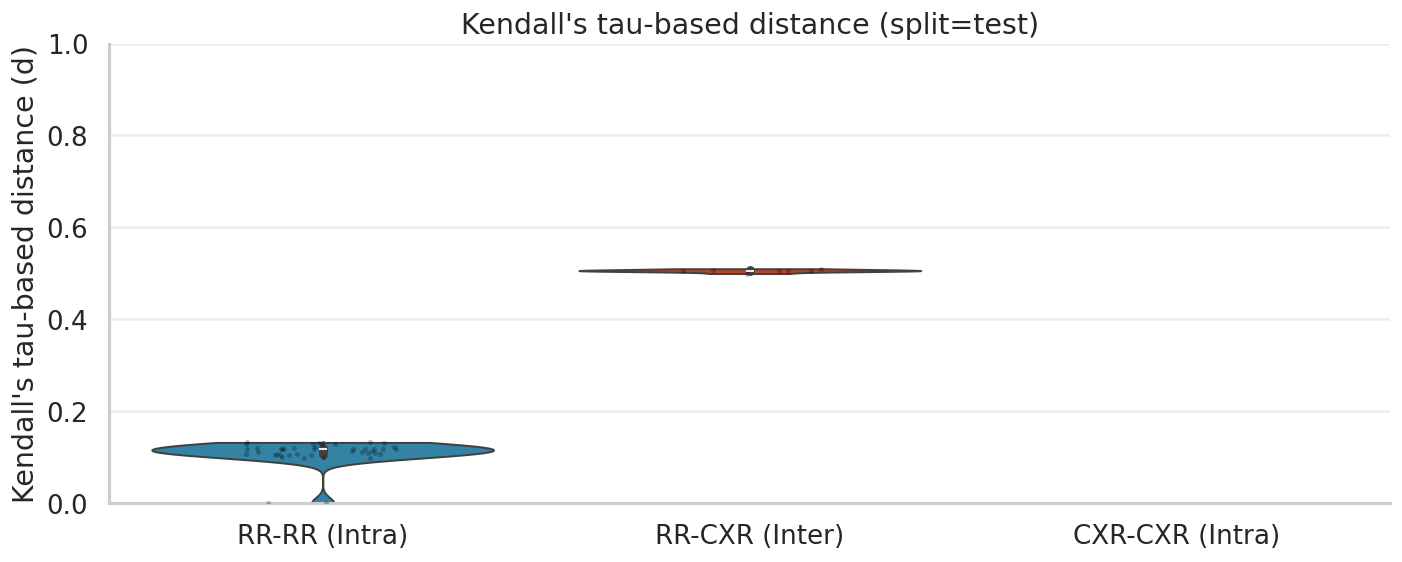

In [17]:
def plot_violin(df: pd.DataFrame, title: str = None):
    fig, ax = plt.subplots(figsize=(12, 5))

    if df is None or len(df) == 0:
        ax.text(0.5, 0.5, 'No pairwise distances to plot', ha='center', va='center')
        ax.set_axis_off()
        return fig

    # Seaborn v0.14+ warning fix: if you pass palette, also pass hue.
    sns.violinplot(
        data=df,
        x='Category',
        y='distance',
        hue='Category',
        order=CATEGORY_ORDER,
        palette=PALETTE,
        cut=0,
        inner='box',
        linewidth=1.2,
        saturation=0.9,
        legend=False,
        ax=ax,
    )

    sns.stripplot(
        data=df,
        x='Category',
        y='distance',
        order=CATEGORY_ORDER,
        color='black',
        alpha=0.25,
        size=3,
        jitter=0.18,
        ax=ax,
    )

    ax.set_ylabel("Kendall's tau-based distance (d)")
    ax.set_xlabel("")
    if title:
        ax.set_title(title)

    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', alpha=0.35)
    sns.despine(ax=ax)

    plt.tight_layout()
    return fig

fig = plot_violin(
    all_df,
    title=f"Kendall's tau-based distance (split={SPLIT})",
)
plt.show()